<h3>"Call a daggum timeout!"</h3>

-Roy Williams, probably never

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Certain coaches (famously, Roy Williams) are often criticized for not calling timeouts in an attempt to end a run. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. I intend to use a large dataset (all of the play-by-play data available from ESPN) and some straightforward statistical analysis to show that calling timeouts midgame to end scoring runs has minimal effect on stopping scoring runs.

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of their possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should occur in most basketball contests. In the same way, these scoring runs should be expected to follow similar probability distributions for when they end. That is, after a scoring run starts, it should have a predictable probability of ending due to the same probabilities. I am going to show that calling a timeout either does not speed up the rate at which a run ends or even negatively increases the length of the run (both teams get to use the timeout, why wouldn't the running team also be able to rest and improve their strategy?).

In other words, I believe that far too much emphasis is placed on "momentum", and players should be expected to recognize these "slumps" and "streaks" as statistically probable events; that is, these scoring streaks and slumps should be expected to regress to the mean over time and end naturally. I believe timeouts have no effect on the ability of a team to recover from such a streak or slump. 

Another factor in real basketball games that needs to be considered is the fact that basketball has very frequent time stoppages. In this analysis, stoppages other than timeouts will not be included as causes for "settling" a run, but it stands to reason that timeouts become even less necessary when other time stoppages are considered, as the break in play provides time for quick communication from a coach, substitution of players for tired/injured/otherwise hindered players or better match ups, and, more importantly, settling "frazzled" players, which is the most common justification for this strategy. In future works, I'd like to explore whether this conjecture about the positive effects of other stoppages in play is true.

Additionally, I believe that experience with these events, i.e., "playing through" a cold streak or weathering runs towards the ends of games, results in increased overall win percentage and, in particular, post-season success. In the future, I'd also like to perform a similar analysis on games presumably lost due to running out of timeouts. <a href="https://youtu.be/7HhZBaCAa80?t=702">Here's a nice example.</a>

<b>Disclaimer: This is all an exercise in probability and data scraping. I do believe that there are mental components to athletic contests, and scoring is not independent of these factors. However, I think that a coach could easily coach their team to not expect or wait for timeouts in the case of runs, and it would not have a negative effect on their performance.</b>

Now, to perform this analysis, we need to identify the beginnings and ends of runs. Obviously, there is no objective "best" way to decide these properties, so I attempted to write all of the analysis with a great deal of flexibility and across ranges of values. I made best guesses using values that I considered justifiable. These values are used to find sequences of events that have characteristics we've identified as runs. Using the runs we find and Bayes' Theorem, we'll show that calling timeouts does not stop runs and likely has a negative effect on the ending of a run.

Back for more TO analysis! This time we are using a better analysis to compare runs in a way that matches exact sequences to other sequences and determining what happened after those sequences.

Briefly, the method consists of converting the scores into a code H or A indicating Home or Away followed by the value of the basket (1-3) or a T for timeout (OT for official timeouts). This method produces a string like "H2A2A2A2H2H2H2A2H2OTATH2A2H3OTHTH1H1A2H2H2H1H1A2H1H1H2A2OTHTH2H2H2H1H1H1A1H2A3OTHTH1H2A2". We then use a regular expression search to find all sequences that look like a run. This method is substantially faster than the previous approach, so we use any sequence of 2 or more baskets in a row. We can eliminate some of the shorter runs based on the value of the run. For example, H1H1 for two consecutive made free throws can be found as a run. We can easily eliminate those results by only looking at runs with score values greater than some predefined value (e.g., 6).

After finding sequences that match the run criteria, we collect the next 5 events (TOs and scores). We may be interested in extending this length or performing a sensitivity analysis on this length, but we'll get to that later. We then divide the runs based on the event that ended the run (TO by type or opponent score) and record the different score values after the the end of the run (<b>At this point, one fewer event is totaled for the </b>.

The results are plotted

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hiddenby default for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>. 
Some of the analysis may be a bit disjoint without the comments in the code. If you are
comfortable reading Python, consider viewing the code, althought it can be a bit long at times.''')

In [29]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sqlite3
import re
from collections import defaultdict

to_names = ['No TO', 'No TO -1','TO', 'Away TO', 'Home TO','Official TO']

def read_dictionary(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename, encoding='latin-1') as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

def write_dict(outputfilename, dictionary):
    """
    Writes a dictionary to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        for key, value in dictionary.items():
            outfile.write('%s,%s\n' % (key, value))
            
def write_list(outputfilename, list):
    """
    Writes a list to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        itemwriter = csv.writer(outfile, delimiter=",")
        for item in list:
            itemwriter.writerow(item)
            
def read_list(filename):
    """
    Opens the indicated filename and creates a list line by line
    """
    listoutput = []
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            listoutput.append(item)
    return listoutput

def find_run_value(key):
    """
    Takes a sequence of scores (e.g., 'H1H2H2H3H2') and determines the total value of that
    squence. Used to combine different score sequences based on the magnitude of the run.
    
    Values are positive for home streaks and negative for away streaks.
    
    Returns an int.
    """
    run_value = 0
    for c in str(key):
        if c in 'OUT':
            # Should only have scores
            # Should be impossible to pass through Regex, but just in case.
            raise 'Non-scoring event found in run sequence {}'.format(key)
        elif c == 'A':
            sign = -1
        elif c == 'H':
            sign = 1
        else:
            run_value += sign * int(c)
    if run_value == 0:
        raise "Score streak evaluated to 0. Key: {}".format(key)
    return run_value

def find_sequence_value(seq):
    """
    Very similar to find_run_value except that it allows for timeouts in the sequence.
    Could be simplified to one function, this may be slightly more readable.
    
    Returns Int
    """
    seq_value = 0
    to = False
    for c in str(seq):
        # We are going to set the value of timeouts to 0 because we
        # want to be able to subtract the last item so TO runs and non-TO runs
        # have the same length
        if to == True:
            c = 0
            to = False
        elif c in 'OUT':
            to = True
            c = 0
            continue
        elif c == 'A':
            sign = -1
        elif c == 'H':
            sign = 1
        else:
            seq_value += sign * int(c)
    try:
        # Return sequence value and sequence -1 (looking for parity dependence)
        return seq_value, seq_value - sign * int(c) 
    except:
        print(seq)


ABRDict = read_dictionary('./ESPN_scraper/ABRdictionary.csv')
NUMDict = read_dictionary('./ESPN_scraper/NUMdictionary.csv')
game_sequences = read_list('./data/game_sequences.csv')

In [45]:
conn = sqlite3.connect('./data/CBBdb.sqlite3')
curr = conn.cursor()

# Exclude bad data
# It might be possible to salvage some of these games as they were frequently a single line where the
# points were added to the wrong team and corrected on the next line.
data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', '303172239', '290450275',
                        '280472483', '283472390', '290450275', '290650087', '293170041', '260280218', '263240150', 
                        '270170222', '400498526', '400591228', '273332603', '310630171', '253190235', '253532250', 
                        '260020150', '253180142', '253340120', '253422250', '260072608', '260120204', '260230221',
                        '260282507', '260282294', '260310275', '260360152', '263240096', '263330221', '263330264',
                        '263400057', '263572305', '270090275', '270130062', '270152305', '270150097', '270160254',
                        '270232390', '270272305', '270380201', '270460012', '270462509', '270550079', '270672440',
                        '270670120', '273212501', '273512250', '273532086', '280030305', '280050103', '280430258',
                        '280562306', '280590097', '280612181', '280612181', '280660356', '280730235', '283310153',
                        '283402181', '283420052', '290092561', '290350026', '290452752', '290490235', '400869965',
                        '290530183', '290592550', '290660277', '293130153', '293160194', '293172509', '293200041',
                        '293290012', '293392509', '293410251', '293540059', '300090167', '300300096', '303120356',
                        '303160127', '303160062', '303170068', '303172181', '303170036', '303180150', '303180084',
                        '303200097', '303250152', '303300222', '303310251', '303320127', '303360239', '303390030',
                        '303452350', '303480251', '303500142', '303520082', '303580326', '310052633', '310070315',
                        '310090150', '310122599', '310120046', '310120142', '310150145', '310200264', '310350163',
                        '310360097', '310562099', '313160275', '313310221', '313500140', '320140077', '320490305',
                        '323280057', '323300038', '323330156', '330012506', '330712065', '400498358', '400502811',
                        '400507286', '400545134', '400597751', '400589302', '400589302', '400585776', '400586395',
                        '400835654', '253252124', '253262124', '263242124', '273152306', '273302413', '273232124',
                        '283202390', '283270221', '283292124', '283402567', '293190130', '293272124', '400856728',
                        '400841076', '400847079', '400840829', '400833168', '273170026', '273192305', '313500085',
                        '400840099', '313462885', '323652413', '313502751', '303172348', '313462542', '303160349',
                        '300300059', '303162545', '313530239', '400595223', '303160006', '303170055', '400591595',
                        '400817510', '293282124', '400589303', '303262124', '303160151', '303172184', '293512026',
                        '273192305', '400833387', '323650324', '400591290', '303160155', '273210245', '303172169',
                        '303172751', '400588668', '303170357', '400587424', '323652309', '303172086', '293432250',
                        '323652908', '400498590', '400586319', '400590746', '293512166', '323652750', '400840168',
                        '400499958', '273170026', '400513943', '303332306', '400591223', '303160140', '323482439',
                        '400588669', '303182619', '323490013', '400830619', '303162674', '400595362', '323650193',
                        '323652427', '303172515', '400504241', '400586918', '303172737', '323372272', '400818872',
                        '400505535', '303650021', '300070043', '313390050', '303172275', '303160338', '303182515',
                        '313500331')""", conn)
conn.close()
# Ensure that numbers are numeric values and not strings.
data = data.apply(pd.to_numeric,errors='ignore')

In [46]:
print('This is what the data look like:')
data.head(2)

This is what the data look like:


,rowid,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,1,253120183,2005-11-09,0,1194,183,Darryl Watkins missed Two Point Layup.,BCU,SYR,0,0
1,2,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3


In [47]:
# We need to divide games into periods so that we don't span halftime,
# overtime periods or different games. ESPN doesn't mark this difference,
# so we use the time restart (i.e., t2 > t1 where t is decreasing) to indicate 
# the start of a new period or an out of order event (i.e., bad game data).

# CONSIDER using this to split the games. Might be faster.
#https://stackoverflow.com/questions/28911119/split-dataframe-into-two-or-more-parts

# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():
    time = row['time']
    if time > lasttime + 1:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

In [53]:
# Now, we transform the data into strings of scores and timeouts.
# This method is a lot more sensitive to out of order events than the previous method, so I found more bad games
bad_games = []
game_sequences = []
last_game_id = -1
for period in periods:
    game_id = period.game_id.values[0]
    game_sequence = ''
    # We carry the halftime/overtime score and reset on a new game 
    if game_id != last_game_id:
        last_home = 0
        last_away = 0
    for i,row in period.iterrows():
        # Excluding last 90 seconds
        if row.time < 90:
            break
        points = (row.home_score - last_home) - (row.away_score - last_away)
        # We need to make sure that the sequence is accurate, otherwise 2 digit scores throw off the analysis
        if points > 3 or points < -3:
            # This should be empty at the end
            bad_games.append(row.game_id)
        last_home = row.home_score
        last_away = row.away_score
        if 'timeout' in row.event.lower():
            if 'tv' in row.event.lower():
                game_sequence += 'OT'
            if row.actor != -1: # -1 for teams that aren't in the team dictionaries
                if NUMDict[str(row.actor)] in ABRDict[row.home]:
                    game_sequence += 'HT'
                elif NUMDict[str(row.actor)] in ABRDict[row.away]:
                    game_sequence += 'AT'
            else:
                bad_games.append(str(game_id))
        elif points > 0:
            game_sequence += 'H' + str(points)
        elif points < 0: 
            game_sequence += 'A' + str(abs(points))
    # Get current values so we can make sure we have the correct starting score 
    last_game_id = game_id
    last_home = period.iloc[-1].home_score
    last_away = period.iloc[-1].away_score
            
    game_sequences.append([game_id, game_sequence])

# Check a random value to make sure it's correct
print('We transform the above data into a string containing only scoring plays and timeouts:')
print(game_sequences[42])
#print("', '".join(set(bad_games)))
print('Should be an empty list (automatic detection of data corruption):', bad_games) 

We transform the above data into a string containing only scoring plays and timeouts:
[253222250, 'H2H2A1A1H2A2A2H2H1H2H2A2ATA3H2H2H2ATH1A3ATA3A2H2ATH2A2OTHTH2A2H2H2A2HTA3OTHTA1H1']
Should be an empty list (automatic detection of data corruption): []


In [54]:
# Some of the above is a bit slow so we can read/write here
# Used a csv for readability. Pickle would also have worked.
write_list('./data/game_sequences.csv', game_sequences)
#game_sequences = read_list('./data/game_sequences.csv')

Next, we use regex to find everything that happens after any run. We define a run as any number of consecutive scores (including free throws) by a team. Then, we determine what happened after that run (e.g., running team continued to score, teams traded scores, time outs were called, etc.). We collect these data for the duration of the run and then the following 7 events (scores or timeouts).

The example printed below shows the all of the sequences that occurred after the home team scored three 3pts in a row ('H3H3H3').

In [55]:
# Regex search strings
home_run = """(H[1-3]){2,}"""
away_run = """(A[1-3]){2,}"""
# Change to """(H[1-3]){2,}([AOUT1-3]{2}|HT[HAOUT1-3]{10})""". Should be able to get groups directly 
# and should only find sequences where there are enough events after the run simplifying of the code below

full_run_dictionary = defaultdict(list)
for period in game_sequences:
    for run_seq in [home_run, away_run]:
        for start, end in [(m.start(0), m.end(0)) for m in re.finditer(run_seq, period[1])]:
            # The regex does not find overlaps but we want to make sure that we are unbiased in defining what
            # happens next under certain circumstances, so we need to collect subsequences of longer runs
            # As an example, a sequence like H2H3H2H1H1H3H2 will only match once, but we also want to consider
            # H2H3H2 as a run. The regex will find H2H3H2(A[1-3T]|HT) but we need to include the possibility that
            # the run continues
            while end - start >= 4:
                run = period[1][start:end]
                sequence = period[1][end:end+14]
                if sequence:
                    try:
                        full_run_dictionary[run].append(sequence)
                    except:
                        full_run_dictionary[run] = [sequence]
                # Remove the last event and get the shorter sequence
                end -= 2
            
print(full_run_dictionary['H3H3H3'])

['ATA2H2A3H3A3H3', 'H2ATH2A2H2A3OT', 'ATH2OTHTA2H3H2', 'ATA3H3OTHTH2A2', 'ATOTATA1A1A2H3', 'ATH2H1A2H2A2H3', 'ATA3OTHTH2A2H3', 'ATH2OTHTA2H1H2', 'ATOTHTH1H1A2H2', 'ATOTATH3A2H3H3', 'ATH2H3A2OTATA1', 'H2', 'A2H2A3H3', 'ATA2A2HTOTHTH3', 'ATA2H2A2OTHTH3', 'H1A1A1OTHTH1H1', 'H3A2A1H2OTATA1', 'A2H2OTATA2OTAT', 'A3H2A2HTOTHTH1', 'ATH2OTHTH2A2', 'ATOTATA2H1H1OT', 'ATOTHTATH2A2H2', 'H1H1OTATH3A1A1', 'OTHTH1H2A2HTH2', 'H2ATA3H2A2OTAT', 'H2OTHTH1H2A3H2', 'OTATA1A1H2H1H1', 'ATA2H1H2OTHTH1', 'A2H3A2OTATA2H2', 'OTATH3A1A1H2A1', 'A1A1H2ATA1A1H2', 'ATA2A2H2H2OTAT', 'H3H2ATOTHTA2H3', 'A2H2OTATA1HTH1', 'ATA2OTATA2H2H2', 'ATA3H2A2OTHTH1', 'A3A1A1H2H2ATH3', 'ATOTHTH2H1H1A1', 'A1A1H3H2A2H3AT', 'ATA1OTATA1H2A3', 'A3H2A2H3H2A2H2', 'ATA1H2H1A2A1A2', 'ATA2H2A3H3OTAT', 'ATA2HTH2A3OTHT', 'OTHTH1A1A1', 'A3H2OTATA1A1H3', 'ATA3A2OTATH3A1', 'OTHTH2A3HT', 'ATA2OTATH1H1H2', 'ATA2A2H2H2H2OT', 'H3ATH2OTATA2H1', 'ATH2H1H1OTATA1', 'ATA1A2H2OTHTH2', 'OTHTA2H2H1A3H2', 'ATA1A1H2A2OTHT', 'ATH2H3A2H2H2H2', 'A3H1H1A3H3OTHT', '

There are a large number of possible scoring sequences. For simplicity, we are going to start by grouping them based on value. The values of the run sequences and the post-run sequences will be calculated and separated based on whether the run is "terminated" by a timeout and who the timeout caller was (official, home team, away team). Run values are calculated to be positive for the home team and negative for the away team so that we can easily correlate run continuation or ending based on the sign of the average.

In [56]:
# Here we find out how much each sequence is worth and the value of the scores after the timeout
# We produce a list of [run_sequence, value of run, [lists of values of post TO sequences by type of timeout]]
# that is, [no timeout, all timeouts, official timeout, home timeout, away timeout]

TO_run_count = 0
other_count = 0
score_histograms = []
for key in full_run_dictionary:
    run_value = find_run_value(key)
    # Empty lists for the various situations. Maybe make a class to hold all of these
    # Probably easier to read this as a script than make the whole thing into a bunch of objects
    seq_values = {'NoT': [],
                'NoT-1': [],
                'HT': [],
                'HT-1': [],
                'AT': [],
                'AT-1': [],
                'OT': [],
                'OT-1': [],}
    TO_run = False
    for seq in full_run_dictionary[key]:
        # Find values of the runs and sort them based on whether a TO was called and who called it.
        seq_value, seq_v_less1 = find_sequence_value(seq)
        caller = seq[0] if seq[1] in 'AHOU' else 'No'
        seq_values[caller + 'T'].append(seq_value)
        seq_values[caller + 'T-1'].append(seq_v_less1)
    # Adds the above calculated and divided values to a list.
    score_histograms.append([key, run_value, seq_values])
        
print(len(score_histograms))

1155


In [7]:
#

In [58]:
# find the max and min run values from above
min_run = 0
max_run = 0
for extremes in score_histograms:
    if extremes[1] < min_run:
        min_run = extremes[1]
    if extremes[1] > max_run:
        max_run = extremes[1]

combined = {}
for values in score_histograms:
    for seq_type in values[2].keys():
        # combined[(score, to type)]
        combined.get((values[1], seq_type), []).extend(values[2][seq_type])

TypeError: list indices must be integers or slices, not str

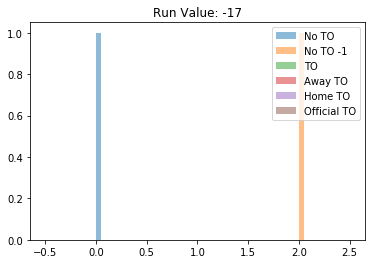

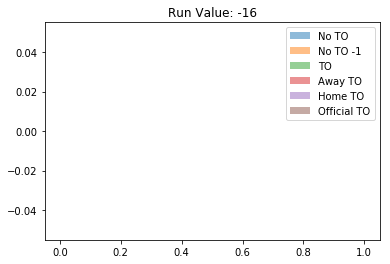

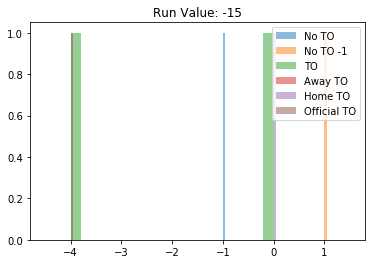

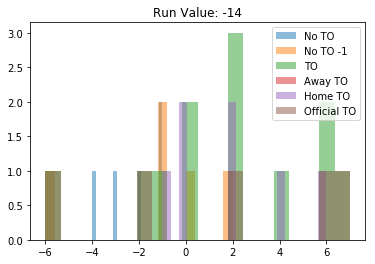

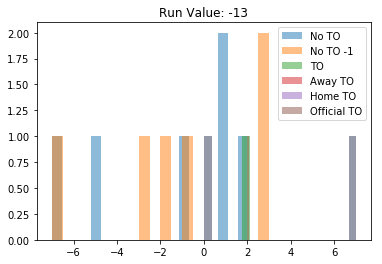

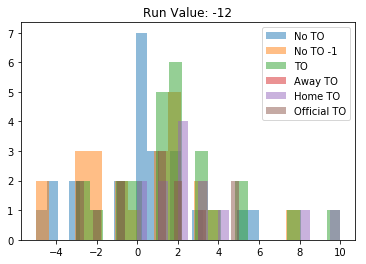

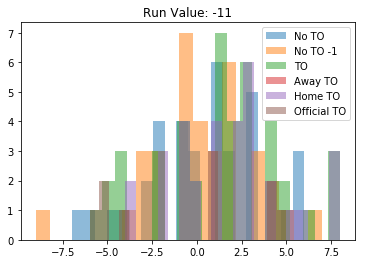

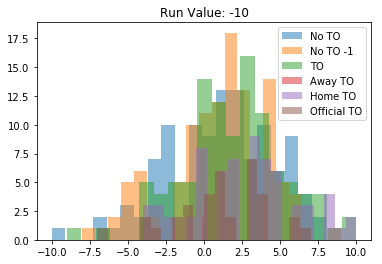

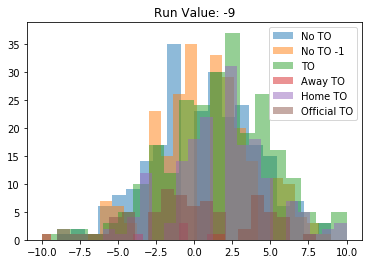

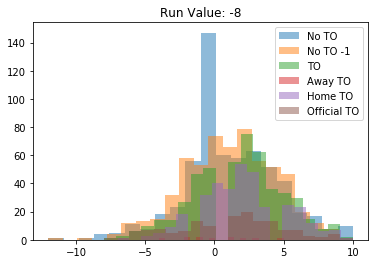

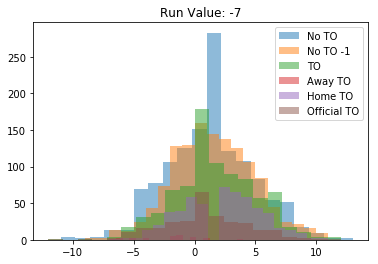

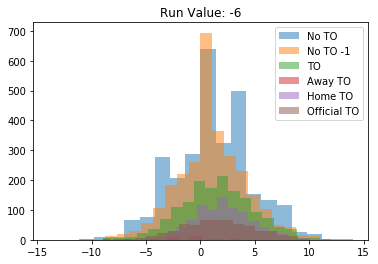

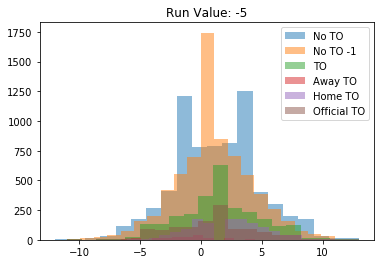

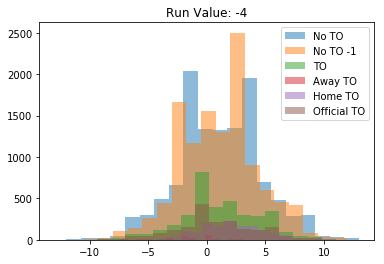

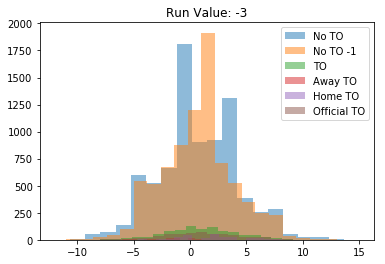

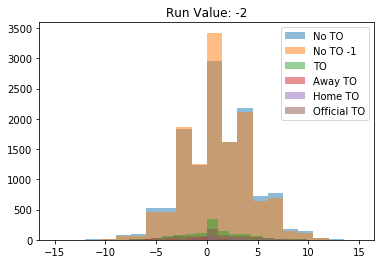

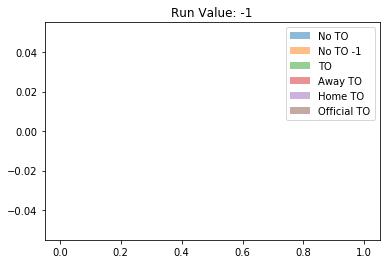

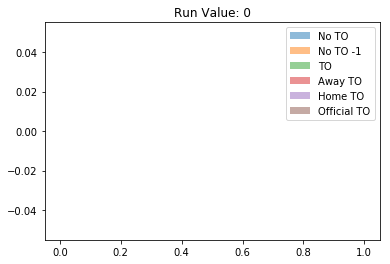

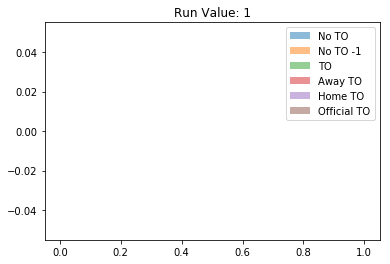

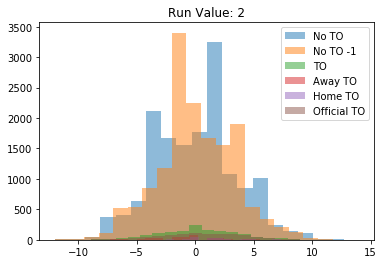

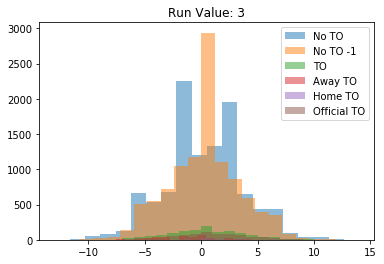

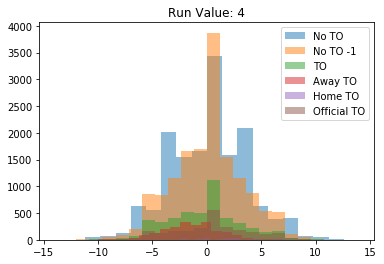

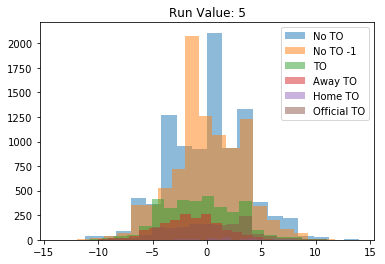

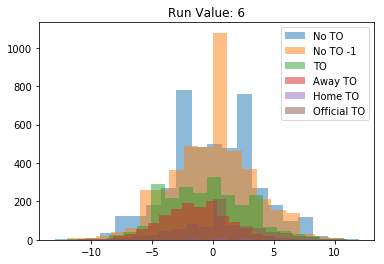

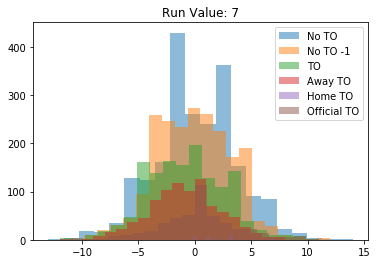

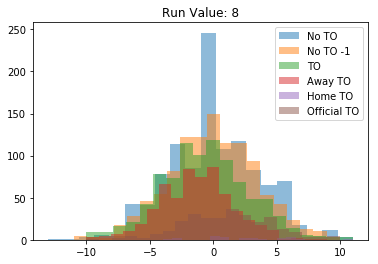

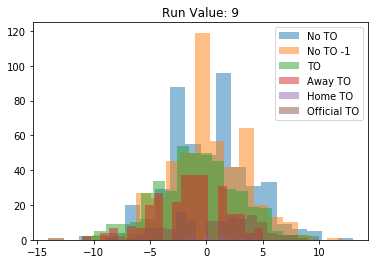

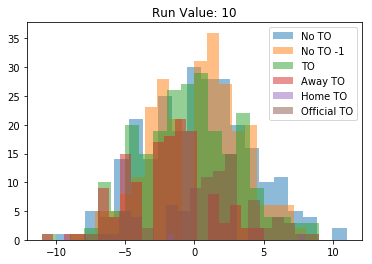

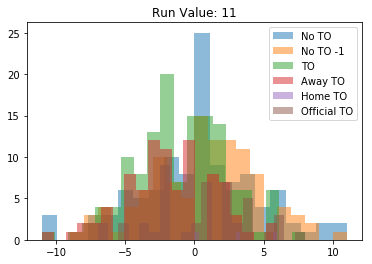

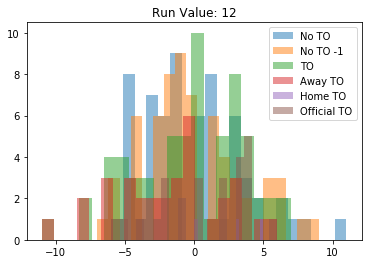

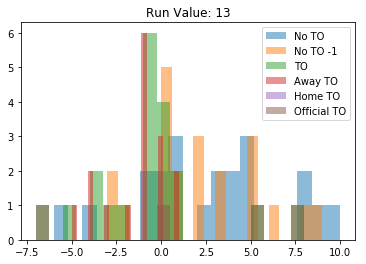

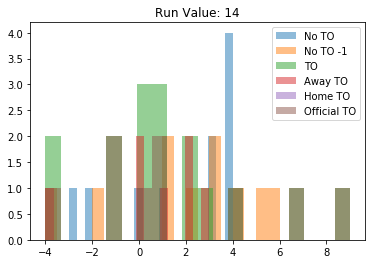

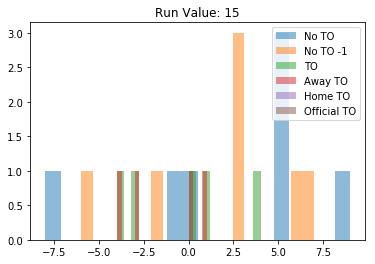

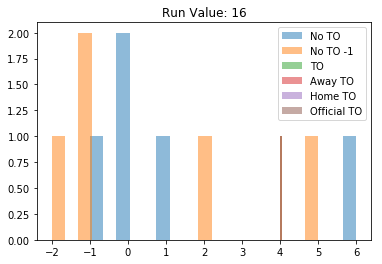

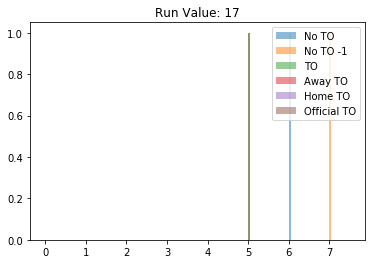

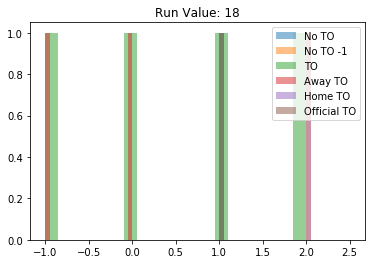

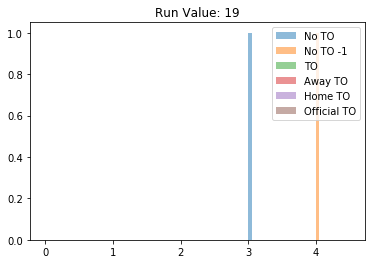

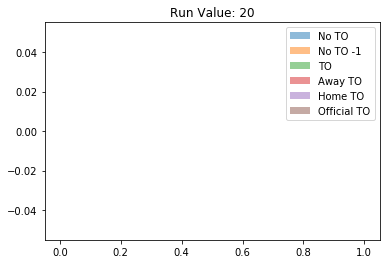

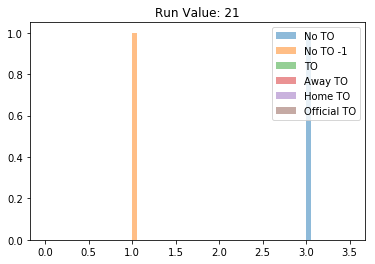

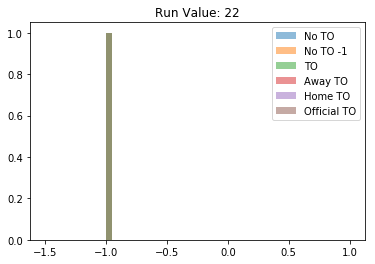

In [9]:
# These are lists of each type of run according to 
# to_names = ['No TO', 'No TO -1','TO', 'Away TO', 'Home TO','Official TO']
# defined in the first code box
# 
h_values = [[],[],[],[],[],[]]
h_averages = [[],[],[],[],[],[]]
h_std = [[],[],[],[],[],[]]

a_values = [[],[],[],[],[],[]]
a_averages = [[],[],[],[],[],[]]
a_std = [[],[],[],[],[],[]]

for i,histo in enumerate(combined):
    #for j, to_name in enumerate(to_names):
    #    plt.hist(histo[j], bins=20, alpha=0.5, label=to_name) 
    #plt.title('Run Value: ' + str(i+min_run))
    #plt.legend(loc='upper right')
    #plt.show()
    for k, to_hist in enumerate(histo):
        # Run value is positive
        if i+min_run >= 0: # Add to Home runs
            try:
                # If we don't have any data, don't add to either list
                # make sure to check len(to_type) first
                h_averages[k].append(sum(to_hist)/len(to_hist))
                h_values[k].append(i+min_run)
                h_std[k].append(np.std(to_hist)) # Should this be standard error instead?
            except:
                continue
        else: # Run value is negative, add to away runs
            try:
                a_averages[k].append(sum(to_hist)/len(to_hist))
                a_values[k].append(i+min_run)
                a_std[k].append(np.std(to_hist))
            except:
                continue
        

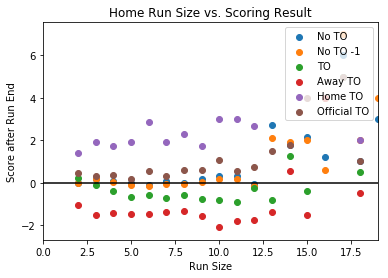

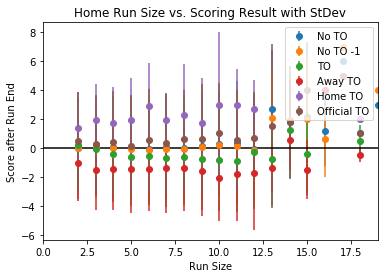

In [10]:
for i,to_name in enumerate(to_names):
    plt.scatter(h_values[i], h_averages[i], marker='o', label=to_name)
    
plt.plot((0, 19), (0, 0), 'k-') # Add line at zero
plt.xlim(0,19)
plt.title('Home Run Size vs. Scoring Result')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='upper right')
plt.show()


for i,to_name in enumerate(to_names):
    plt.errorbar(h_values[i], h_averages[i], h_std[i], linestyle='', marker='o', label=to_name)   
    
plt.plot((0, 19), (0, 0), 'k-')
plt.xlim(0,19)
plt.title('Home Run Size vs. Scoring Result with StDev')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='upper right')
plt.show()



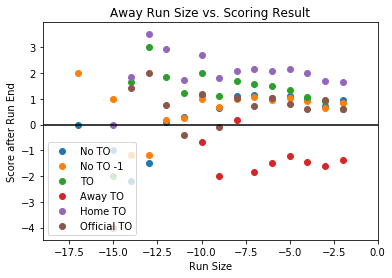

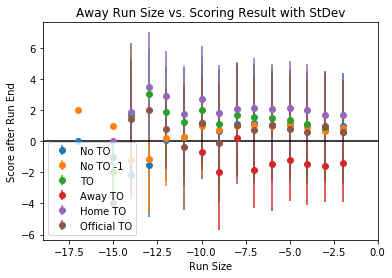

In [11]:
for i,to_name in enumerate(to_names):
    plt.scatter(a_values[i], a_averages[i], marker='o', label=to_name)
    
plt.plot((-19,0), (0, 0), 'k-')
plt.xlim(-19,0)
plt.title('Away Run Size vs. Scoring Result')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='lower left')
plt.show()


for i,to_name in enumerate(to_names):
    plt.errorbar(a_values[i], a_averages[i], a_std[i], linestyle='', marker='o', label=to_name)   
    
plt.plot((-19, 0), (0, 0), 'k-')
plt.xlim(-19,0)
plt.title('Away Run Size vs. Scoring Result with StDev')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='lower left')
plt.show()

In [22]:
#print(score_histograms[0])

In [18]:
min_run = 0
max_run = 0
for extremes in score_histograms:
    if extremes[1] < min_run:
        min_run = extremes[1]
    if extremes[1] > max_run:
        max_run = extremes[1]
        
# Make arrays to store the histograms combined by the score value
# I found this easier to parse than usining another list
# Although we do zip it at the end but whatever
combined_by_value = [[] for i in range(max_run - min_run+1)]
less1_combined_by_value = [[] for i in range(max_run - min_run+1)]
to_combined_by_value = [[] for i in range(max_run - min_run+1)]
a_combined_by_value = [[] for i in range(max_run - min_run+1)]
h_combined_by_value = [[] for i in range(max_run - min_run+1)]
o_combined_by_value = [[] for i in range(max_run - min_run+1)]

print(max_run - min_run+1)

for record in score_histograms:
    combined_by_value[record[1]-min_run].extend(record[2][0])
    less1_combined_by_value[record[1]-min_run].extend(record[2][1])
    to_combined_by_value[record[1]-min_run].extend(record[2][2])
    a_combined_by_value[record[1]-min_run].extend(record[2][3])
    h_combined_by_value[record[1]-min_run].extend(record[2][4])
    o_combined_by_value[record[1]-min_run].extend(record[2][5])

combined = zip(combined_by_value, less1_combined_by_value, to_combined_by_value, a_combined_by_value, h_combined_by_value, o_combined_by_value)
        

40


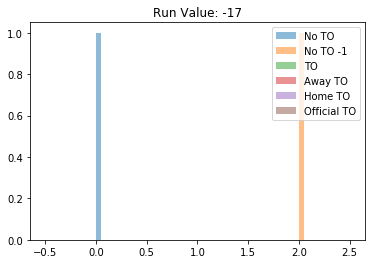

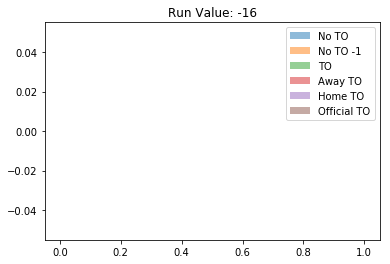

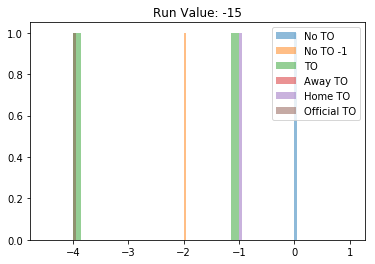

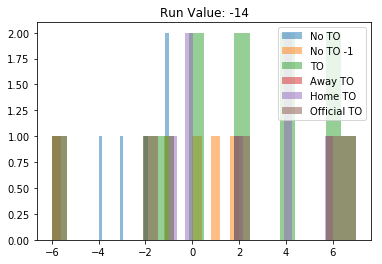

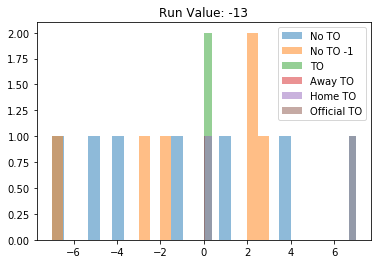

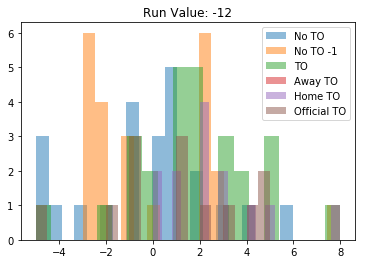

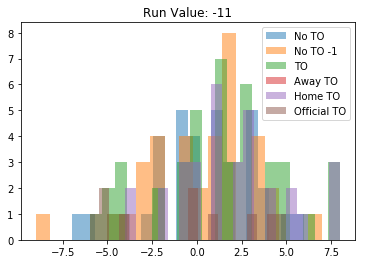

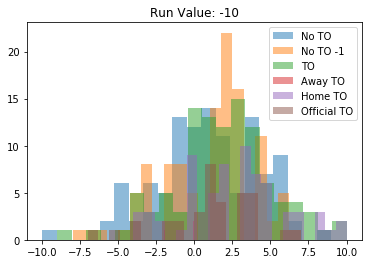

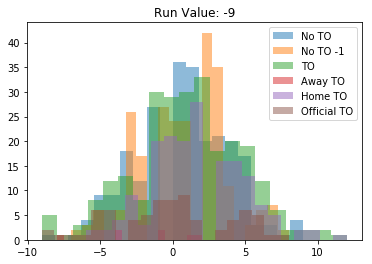

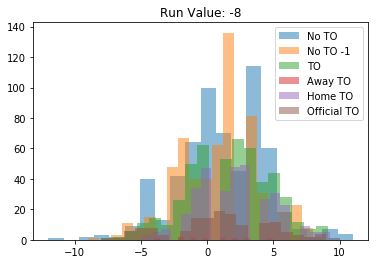

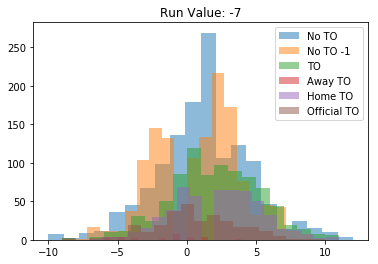

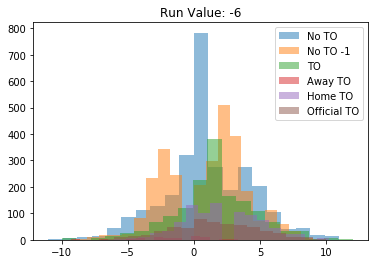

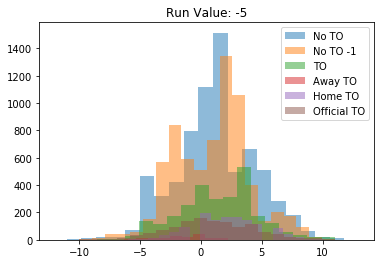

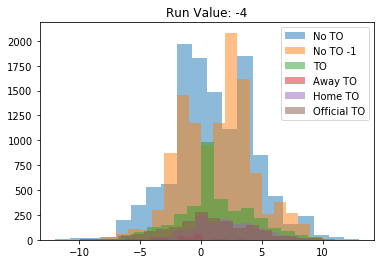

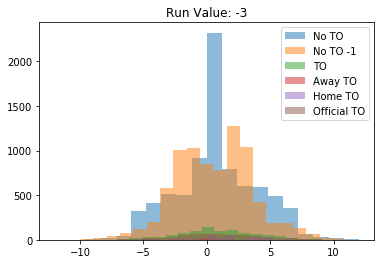

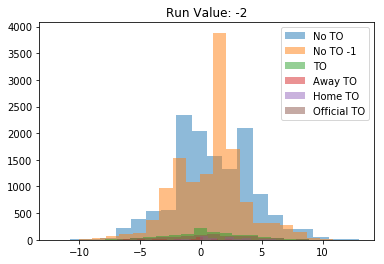

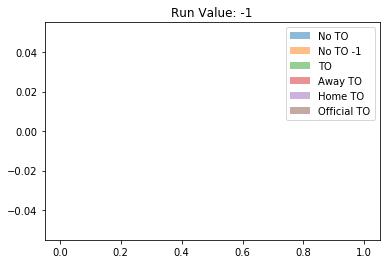

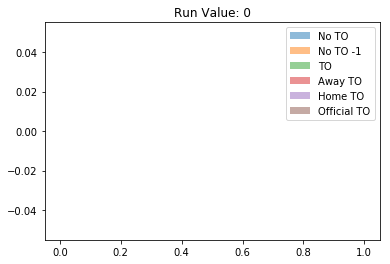

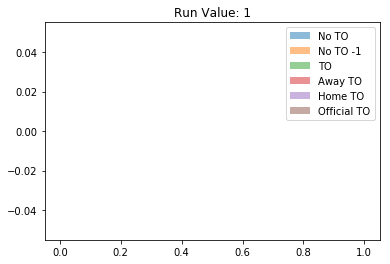

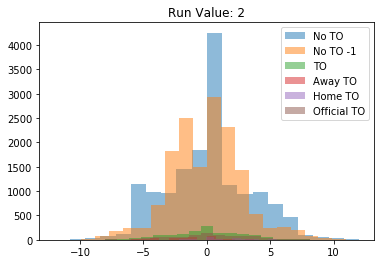

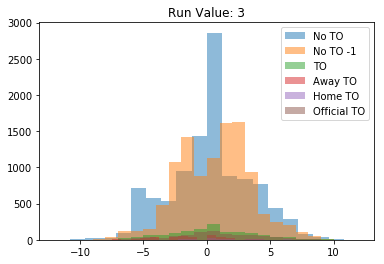

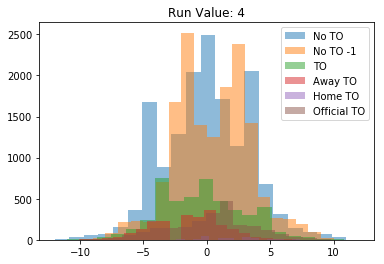

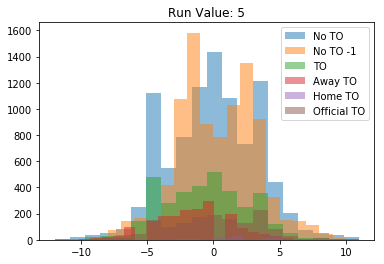

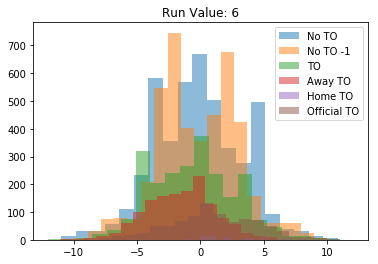

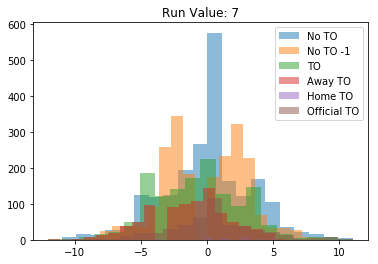

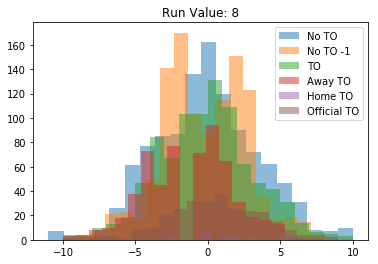

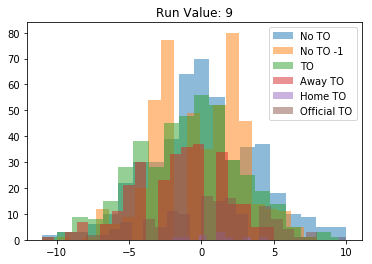

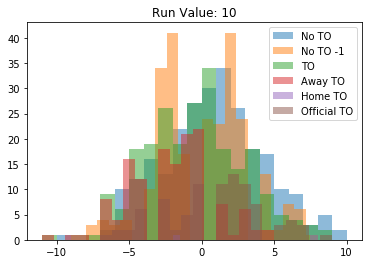

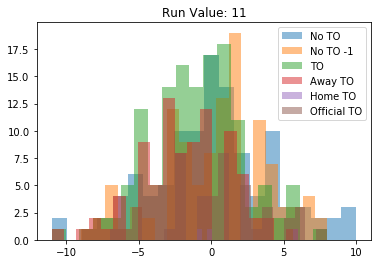

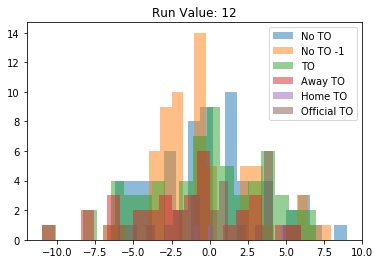

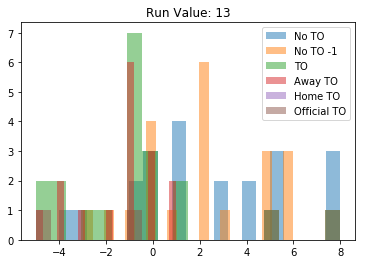

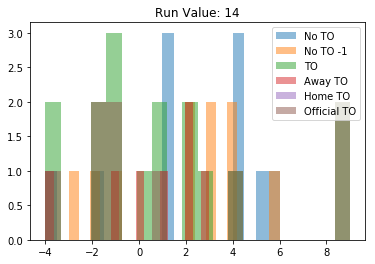

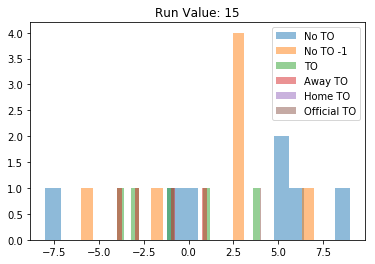

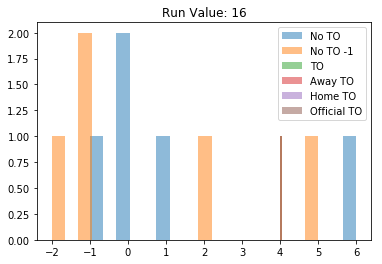

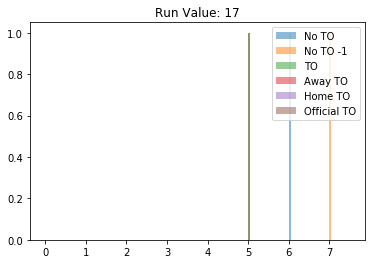

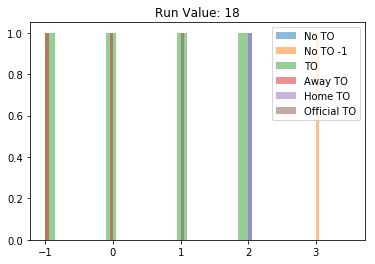

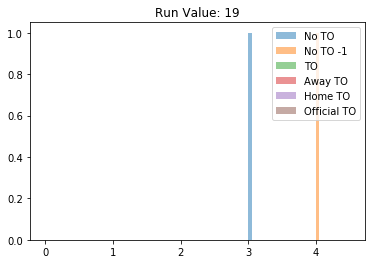

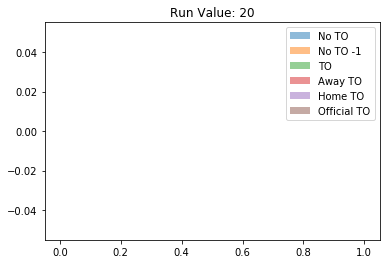

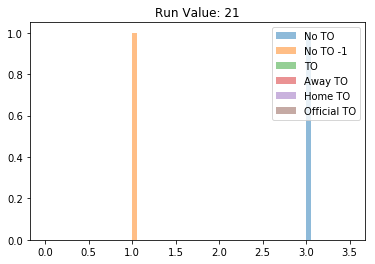

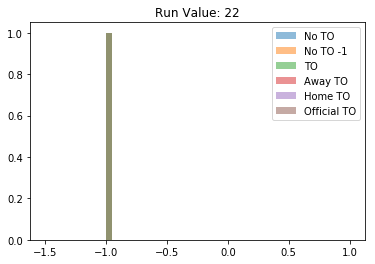

In [19]:
h_values = [[],[],[],[],[],[]]
h_averages = [[],[],[],[],[],[]]
h_std = [[],[],[],[],[],[]]

a_values = [[],[],[],[],[],[]]
a_averages = [[],[],[],[],[],[]]
a_std = [[],[],[],[],[],[]]

for i,histo in enumerate(combined):
   
    for j, to_name in enumerate(to_names):
        plt.hist(histo[j], bins=20, alpha=0.5, label=to_name)
    
    plt.title('Run Value: ' + str(i+min_run))
    plt.legend(loc='upper right')
    plt.show()
    
    for k, to_hist in enumerate(histo):
        
            if i+min_run >= 0:
                try:
                    # If we don't have any data, don't add to either list
                    # make sure to check len(to_type) first
                    h_averages[k].append(sum(to_hist)/len(to_hist))
                    h_values[k].append(i+min_run)
                    h_std[k].append(np.std(to_hist))
                except:
                    continue
            else:
                try:
                    a_averages[k].append(sum(to_hist)/len(to_hist))
                    a_values[k].append(i+min_run)
                    a_std[k].append(np.std(to_hist))
                except:
                    continue

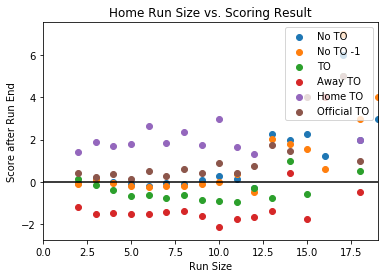

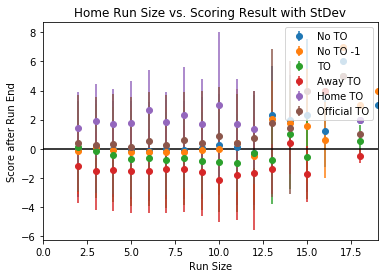

In [20]:
for i,to_name in enumerate(to_names):
    plt.scatter(h_values[i], h_averages[i], marker='o', label=to_name)
    
plt.plot((0, 19), (0, 0), 'k-')
plt.xlim(0,19)
plt.title('Home Run Size vs. Scoring Result')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='upper right')
plt.show()


for i,to_name in enumerate(to_names):
    plt.errorbar(h_values[i], h_averages[i], h_std[i], linestyle='', marker='o', label=to_name)   
    
plt.plot((0, 19), (0, 0), 'k-')
plt.xlim(0,19)
plt.title('Home Run Size vs. Scoring Result with StDev')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='upper right')
plt.show()



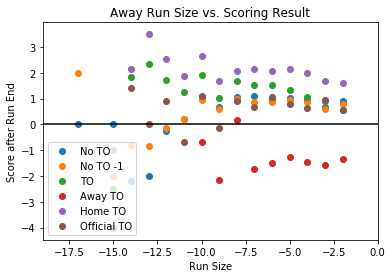

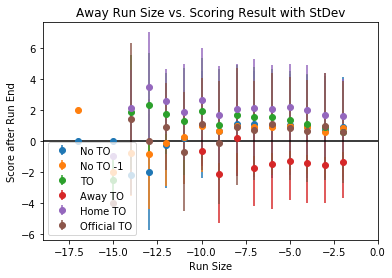

In [21]:
for i,to_name in enumerate(to_names):
    plt.scatter(a_values[i], a_averages[i], marker='o', label=to_name)
    
plt.plot((-19,0), (0, 0), 'k-')
plt.xlim(-19,0)
plt.title('Away Run Size vs. Scoring Result')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='lower left')
plt.show()


for i,to_name in enumerate(to_names):
    plt.errorbar(a_values[i], a_averages[i], a_std[i], linestyle='', marker='o', label=to_name)   
    
plt.plot((-19, 0), (0, 0), 'k-')
plt.xlim(-19,0)
plt.title('Away Run Size vs. Scoring Result with StDev')
plt.xlabel('Run Size')
plt.ylabel('Score after Run End')
plt.legend(loc='lower left')
plt.show()

In [ ]:
#Plot histograms for all of different found sequences
# Some of the density is quite low, so we are going to aggregate these data
# by the value of the run. However, it may be interesting to look at this in the future

# all_h_values = [[],[],[],[],[],[]]
# all_h_averages = [[],[],[],[],[],[]]
# all_h_std = [[],[],[],[],[],[]]

# all_a_values = [[],[],[],[],[],[]]
# all_a_averages = [[],[],[],[],[],[]]
# all_a_std = [[],[],[],[],[],[]]

# for gram in score_histograms:
#     for i,to_name in enumerate(to_names):
#         plt.hist(gram[2][i], bins=10, alpha=0.5, label=to_name)
        
# #         if gram[1] >= 0:
# #             try:
# #                 all_h_averages[k].append(sum(to_hist)/len(to_hist))
# #                 all_h_values[k].append(gram[1])
# #                 all_h_std[k].append(np.std(to_hist))
# #             except:
# #                 continue
# #         else:
# #             try:
# #                 all_a_averages[k].append(sum(to_hist)/len(to_hist))
# #                 all_a_values[k].append(i+min_run)
# #                 all_a_std[k].append(np.std(to_hist))
# #             except:
# #                 continue
#     #plt.legend(loc='upper right')
#     plt.title(gram[0] + ' -- Run Value: ' + str(gram[1]))
#     plt.show()

In [ ]:
#data.loc[(data.game_id == 253120183)]

In [ ]:
# Nice little alert to let me know when the Notebook has finished
from IPython.display import HTML
HTML('''<script>
alert('Done!')
</script>''')